<a href="https://colab.research.google.com/github/yoursemicolon/hydromon-machine-learning/blob/main/notebook/training_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predict control action in hydroponic system**
## **Multiclass Classification**

Multiclass classification are those predictive modeling problems where examples are assigned one or more than two classes. The problem here is to predict numeric value from hydroponic parameters, where each class is assigned a unique integer value as the label from 0 to 17. The goal is to predict the probability of the example belonging to each known class.

## **Label and Action**



*   Label 0 : No action
*   Label 1 : Pump Water
* Label 2 : Light On
* Label 3 : Pump Nutrient
* Label 4 : pH Up
* Label 5 : pH Down
* Label 6 : Pump Water + Light On
* Label 7 : Pump Water + pH Up
* Label 8 : Pump Water + pH Down
* Label 9 : Pump Water + Light On + pH Up
* Label 10 : Pump Water + Light On + pH Down
* Label 11 : Light On + Pump Nutrient
* Label 12 : Light On + pH Up
* Label 13 : Light On + pH Down
* Label 14 : Light On + Pump Nutrient + pH Up
* Label 15 : Light On + Pump Nutrient + pH Down
* Label 16 : Pump Nutrient + pH Up
* Label 17 : Pump Nutrient + pH Down





# **Import Library**

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten

print(tf.__version__)

2.8.2


## **Load Data**

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup, SoupStrainer

html = requests.get('https://github.com/HydroMon/hydromon-machine-learning/tree/main/dataset/ver2_training')

dfs = []
for link in BeautifulSoup(html.text, parse_only=SoupStrainer('a')):
    if hasattr(link, 'href') and link['href'].endswith('.csv'):
        url = 'https://github.com'+ link['href'].replace('/blob/', '/raw/')
        dfs.append(pd.read_csv(url))
df = pd.concat(dfs)

df

,Date,Time,ID,TDS,Light Intensity,pH,Air Temperature,Humidity,EC,Label
0,2022-05-20,11:34:05,40TWL4,993,689,6.268,31,98,2.248,0
1,2022-05-20,11:34:10,40TWL4,735,462,6.044,27,46,2.887,0
2,2022-05-20,11:34:15,40TWL4,750,778,5.599,38,53,2.953,0
3,2022-05-20,11:34:20,40TWL4,934,491,6.090,38,45,2.114,0
4,2022-05-20,11:34:25,40TWL4,769,754,6.253,28,27,3.499,0
...,...,...,...,...,...,...,...,...,...,...
995,2022-05-20,01:27:00,40TWL4,1378,880,4.014,29,19,3.097,9
996,2022-05-20,01:27:05,40TWL4,1023,846,4.585,23,78,3.117,9
997,2022-05-20,01:27:10,40TWL4,1219,969,4.728,38,87,2.850,9
998,2022-05-20,01:27:15,40TWL4,1019,866,5.272,20,23,3.179,9


In [ ]:
# use certain features only
df = df.loc[:, ["TDS", "Light Intensity", "pH", "Label"]]
df 

,TDS,Light Intensity,pH,Label
0,993,689,6.268,0
1,735,462,6.044,0
2,750,778,5.599,0
3,934,491,6.090,0
4,769,754,6.253,0
...,...,...,...,...
995,1378,880,4.014,9
996,1023,846,4.585,9
997,1219,969,4.728,9
998,1019,866,5.272,9


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TDS              18000 non-null  int64  
 1   Light Intensity  18000 non-null  int64  
 2   pH               18000 non-null  float64
 3   Label            18000 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 703.1 KB


## **Data Preprocessing**

In [ ]:
# data shuffling
df = df.sample(frac=1).reset_index(drop=True)
df

,TDS,Light Intensity,pH,Label
0,1139,962,5.709,6
1,684,995,5.836,11
2,1151,985,7.007,10
3,1028,575,4.542,7
4,972,554,4.788,4
...,...,...,...,...
17995,1346,884,6.145,6
17996,662,988,7.581,15
17997,1388,856,6.489,6
17998,1121,951,4.441,9


In [ ]:
# split into input and output columns
# input = pH, TDS, Light Intensity
# output = labels
X, y = df.values[:, :-1], df.values[:, -1]

In [ ]:
# input
print("Input Data:")
print(X)

# output
print("Output: ")
print(y)

Input Data:
[[1139.     962.       5.709]
 [ 684.     995.       5.836]
 [1151.     985.       7.007]
 ...
 [1388.     856.       6.489]
 [1121.     951.       4.441]
 [ 459.     920.       5.885]]
Output: 
[ 6. 11. 10. ...  6.  9. 11.]


The de facto standard way of declaring model inputs and outputs is to use numpy, a Python library that provides lots of array type data structures. 

In [ ]:
# ensure all input data are floating point values
X = X.astype('float32')
X

array([[1139.   ,  962.   ,    5.709],
       [ 684.   ,  995.   ,    5.836],
       [1151.   ,  985.   ,    7.007],
       ...,
       [1388.   ,  856.   ,    6.489],
       [1121.   ,  951.   ,    4.441],
       [ 459.   ,  920.   ,    5.885]], dtype=float32)

In [ ]:
print(X.shape, y.shape)

(18000, 3) (18000,)


In [ ]:
# split into input and output columns
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(14400, 3) (3600, 3) (14400,) (3600,)


In [ ]:
X_train

array([[ 968.   ,  675.   ,    5.622],
       [ 779.   ,  484.   ,    5.794],
       [ 536.   ,  827.   ,    5.659],
       ...,
       [ 669.   ,  645.   ,    7.195],
       [ 790.   ,  818.   ,    5.728],
       [1480.   ,  787.   ,    4.265]], dtype=float32)

In [ ]:
X_test

array([[ 889.   ,  917.   ,    5.46 ],
       [ 587.   ,  810.   ,    4.097],
       [ 321.   ,  647.   ,    4.366],
       ...,
       [ 639.   ,  504.   ,    7.547],
       [ 672.   ,  978.   ,    7.537],
       [1390.   ,  761.   ,    5.127]], dtype=float32)

### **Data Normalization After Train-Test Split**
To avoid data leakage.

In [ ]:
from sklearn import preprocessing

column = ['pH','TDS','Light Intensity']

# min max scaler
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))

In [ ]:
# X_train normalization and convert to dataframe
norm_x_train = pd.DataFrame(min_max_scaler.fit_transform(X_train), columns=column)
norm_x_train

,pH,TDS,Light Intensity
0,0.556667,0.458333,0.40550
1,0.399167,0.140000,0.44850
2,0.196667,0.711667,0.41475
3,0.554167,0.545000,0.58200
4,0.195833,0.911667,0.30450
...,...,...,...
14395,0.858333,0.411667,0.48425
14396,0.663333,0.121667,0.33075
14397,0.307500,0.408333,0.79875
14398,0.408333,0.696667,0.43200


In [ ]:
# X_test normalization and convert to dataframe
norm_x_test = pd.DataFrame(min_max_scaler.fit_transform(X_test), columns=column)
norm_x_test

,pH,TDS,Light Intensity
0,0.490833,0.861667,0.364933
1,0.239167,0.683333,0.024012
2,0.017500,0.411667,0.091296
3,0.655000,0.820000,0.165082
4,0.553333,0.388333,0.366933
...,...,...,...
3595,0.543333,0.975000,0.508754
3596,0.827500,0.945000,0.409455
3597,0.282500,0.173333,0.886943
3598,0.310000,0.963333,0.884442


In [ ]:
# determine the number of input features
# input = pH, TDS, Light Intensity
n_features = X_train.shape[1]
n_features

3

## **Create Model**

The function requires that the output layer is configured with an n nodes (one for each class), in this case 18 nodes, and a ‘softmax‘ activation in order to predict the probability for each class.

### **Creating a Callback Class**

In [ ]:
# class modelCallback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs={}):
#     # check accuracy
#     if logs.get('accuracy') is not None and logs.get('accuracy') > 0.99:
#       print("\nReached 99% accuracy so cancelling training!")

#       # stop training once the above condition is met
#       self.model.stop_training = True

This is where it will go through the loop we spoke about above: making a guess, measuring how good or bad it is (aka the loss), using the optimizer to make another guess etc. It will do it for the number of epochs we specify. When we run this code, we'll see the loss on the right hand side.

## **Model Checkpoint & Early Stop**

This function of keras callbacks is used to save the model after every epoch. We just need to define a few of the parameters like where we want to store, what we want to monitor and etc. 

Use the below to code for saving the model. We have first defined the path and then assigned val_loss to be monitored, if it lowers down we will save it. We will again train the network now.

In [ ]:
# add shortcut drive capstone ke drive pribadi
filepath = '/content/drive/My Drive/Company-Based Capstone Project/[C22-HY03] Capstone Project/3.3. System Development/ML/Notebooks/'

from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [checkpoint]

In [ ]:
# stop early
from keras.callbacks import EarlyStopping

stop_early = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
def train_model(x_train, y_train):

    # callbacks = [modelCallback()] # use first callback
    # callbacks = [checkpoint] # use checkpoint
    callbacks = [stop_early, checkpoint] # use stop early and checkpoint
    
    global model
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Dense(128, input_dim=n_features, activation=tf.nn.relu, kernel_initializer='he_normal'), # input layer
        tf.keras.layers.Dense(64, activation=tf.nn.relu, kernel_initializer='he_normal'), # hidden layer
        tf.keras.layers.Dense(32, activation=tf.nn.relu, kernel_initializer='he_normal'), # hidden layer
        tf.keras.layers.Dense(16, activation=tf.nn.relu, kernel_initializer='he_normal'), # hidden layer
        tf.keras.layers.Dense(18, activation=tf.nn.softmax, kernel_initializer='he_normal') # output layer
    ]) 

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy']) 
    # print(model.summary())
    
    # Fit the model for 10 epochs adding the callbacks
    # and save the training history
    history = model.fit(x_train, 
                        y_train, 
                        validation_data=(norm_x_test, y_test),
                        epochs=100, 
                        callbacks=callbacks,
                        batch_size=128,
                        verbose=2)

    return history

## **Training the Neural Network**

In this section, we will investigate loss functions that are approriate for multiclass classification predictive modeling problems.

In [ ]:
hist = train_model(norm_x_train, y_train)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)



Epoch 1: val_loss did not improve from 0.07165
113/113 - 1s - loss: 2.1727 - accuracy: 0.3452 - val_loss: 1.5887 - val_accuracy: 0.5308 - 941ms/epoch - 8ms/step
Epoch 2/100

Epoch 2: val_loss did not improve from 0.07165
113/113 - 0s - loss: 1.1923 - accuracy: 0.6102 - val_loss: 0.9254 - val_accuracy: 0.6778 - 309ms/epoch - 3ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 0.07165
113/113 - 0s - loss: 0.7168 - accuracy: 0.7528 - val_loss: 0.5637 - val_accuracy: 0.8019 - 296ms/epoch - 3ms/step
Epoch 4/100

Epoch 4: val_loss did not improve from 0.07165
113/113 - 0s - loss: 0.4533 - accuracy: 0.8410 - val_loss: 0.4105 - val_accuracy: 0.8431 - 345ms/epoch - 3ms/step
Epoch 5/100

Epoch 5: val_loss did not improve from 0.07165
113/113 - 0s - loss: 0.3436 - accuracy: 0.8756 - val_loss: 0.3344 - val_accuracy: 0.8731 - 323ms/epoch - 3ms/step
Epoch 6/100

Epoch 6: val_loss did not improve from 0.07165
113/113 - 0s - loss: 0.2686 - accuracy: 0.9057 - val_loss: 0.2505 - val_accuracy: 

### **Visualizing loss and validation loss while training**

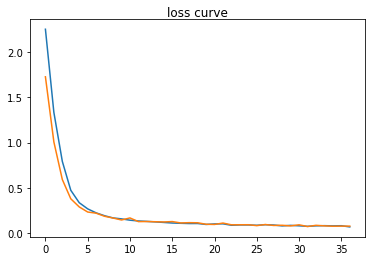

In [ ]:
# import matplotlib.pyplot as plt

# plt.plot(hist.history['loss'], label='train')
# plt.plot(hist.history['val_loss'], label='test')
# # plt.title(f'lrate= {str(lrate)}', pad=-50)
# plt.title('loss curve', pad=-50)
# plt.show()

### **Visualizing accuracy and validation accuracy**

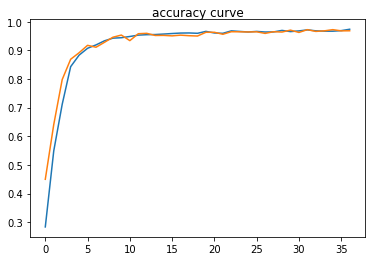

In [ ]:
# plt.plot(hist.history['accuracy'], label='train')
# plt.plot(hist.history['val_accuracy'], label='test')
# # plt.title(f'lrate= {str(lrate)}', pad=-50)
# plt.title('accuracy curve', pad=-50)
# plt.show()

## **Model Evaluation**

### **Training Scores**

In [ ]:
# evaluate the model
# train_loss, train_acc = model.evaluate(norm_x_train, y_train, verbose=2)
# test_lost, test_acc = model.evaluate(norm_x_test, y_test, verbose=2)
# # loss, acc = model.evaluate(X_test, y_test, verbose=2)
# print('Train %s: %.3f' % model.metrics_names[1])
# print('Test accuracy: %.3f' % test_acc)
train_scores = model.evaluate(norm_x_train, y_train, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[0], train_scores[0]*100))
print("%s: %.2f%%" % (model.metrics_names[1], train_scores[1]*100))

loss: 6.15%
accuracy: 97.59%


### **Testing Scores**

In [ ]:
test_scores = model.evaluate(norm_x_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[0], test_scores[0]*100))
print("%s: %.2f%%" % (model.metrics_names[1], test_scores[1]*100))

loss: 8.03%
accuracy: 96.39%


## **Getting testing data for prediction**



Get the data from firestore.

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup, SoupStrainer

html = requests.get('https://github.com/HydroMon/hydromon-machine-learning/tree/main/dataset/ver3_predict')

dfs = []
for link in BeautifulSoup(html.text, parse_only=SoupStrainer('a')):
    if hasattr(link, 'href') and link['href'].endswith('.csv'):
        url = 'https://github.com'+ link['href'].replace('/blob/', '/raw/')
        dfs.append(pd.read_csv(url, nrows=100))
df_predict = pd.concat(dfs)

df_predict

,Date,Time,ID,TDS,Light Intensity,pH,Air Temperature,Humidity,EC,Label
0,2022-05-20,11:34:05,GL5AYT,892,631,5.650,33,77,2.196,0
1,2022-05-20,11:34:10,GL5AYT,726,711,6.089,21,73,2.625,0
2,2022-05-20,11:34:15,GL5AYT,799,424,6.394,29,62,3.146,0
3,2022-05-20,11:34:20,GL5AYT,838,771,6.497,36,30,3.099,0
4,2022-05-20,11:34:25,GL5AYT,747,606,5.931,27,36,2.158,0
...,...,...,...,...,...,...,...,...,...,...
95,2022-05-20,00:12:00,GL5AYT,1402,854,4.893,32,33,2.110,9
96,2022-05-20,00:12:05,GL5AYT,1430,812,4.618,26,57,3.215,9
97,2022-05-20,00:12:10,GL5AYT,1273,824,4.529,28,10,2.743,9
98,2022-05-20,00:12:15,GL5AYT,1152,875,4.198,24,53,3.363,9


In [ ]:
# shuffle data
df_predict = df_predict.sample(frac=1).reset_index(drop=True)
# remove label data
# df_predict = df_predict.drop('Label', 1)
df_predict

,Date,Time,ID,TDS,Light Intensity,pH,Air Temperature,Humidity,EC,Label
0,2022-05-20,14:22:15,GL5AYT,871,932,6.054,34,92,2.913,2
1,2022-05-20,05:41:15,GL5AYT,709,833,6.899,30,44,3.437,13
2,2022-05-20,01:28:45,GL5AYT,1465,971,7.984,31,65,2.860,10
3,2022-05-20,11:41:15,GL5AYT,704,512,5.542,31,94,3.071,0
4,2022-05-20,11:39:05,GL5AYT,854,429,6.191,39,30,2.102,0
...,...,...,...,...,...,...,...,...,...,...
1795,2022-05-20,11:11:15,GL5AYT,448,664,7.552,34,2,2.317,17
1796,2022-05-20,02:52:30,GL5AYT,565,827,6.293,23,35,2.781,11
1797,2022-05-20,08:25:05,GL5AYT,631,982,7.207,28,73,2.931,15
1798,2022-05-20,07:03:10,GL5AYT,439,881,4.471,20,24,3.468,14


##**Making Prediction**

### **Loop Input Data**

In [ ]:
input_data = df_predict.reset_index()
input_data.head()

,index,Date,Time,ID,TDS,Light Intensity,pH,Air Temperature,Humidity,EC,Label
0,0,2022-05-20,14:22:15,GL5AYT,871,932,6.054,34,92,2.913,2
1,1,2022-05-20,05:41:15,GL5AYT,709,833,6.899,30,44,3.437,13
2,2,2022-05-20,01:28:45,GL5AYT,1465,971,7.984,31,65,2.860,10
3,3,2022-05-20,11:41:15,GL5AYT,704,512,5.542,31,94,3.071,0
4,4,2022-05-20,11:39:05,GL5AYT,854,429,6.191,39,30,2.102,0


## **Define Recommendation & Action**

In [ ]:
# action yang akan dilakukan oleh actuator
action = {
    '0' : 'No Action',
    '1' : 'Pump Water',
    '2' : 'Light On',
    '3' : 'Pump Nutrient',
    '4' : 'pH Up',
    '5' : 'pH Down'
}

# recommendation berupa action yg dapat dilakukan
labels = {
    '0' : {
        'recommendation' : [0]
    },
    '1' : {
        'recommendation' : [1]
    },
    '2' : {
        'recommendation' : [2]
    },
    '3' : {
        'recommendation' : [3]
    },
    '4' : {
        'recommendation' : [4]
    },
    '5' : {
        'recommendation' : [5]
    },
    '6' : {
        'recommendation' : [1, 2]
    },
    '7' : {
        'recommendation' : [1, 4]
    },
    '8' : {
        'recommendation' : [1, 5]
    },
    '9' : {
        'recommendation' : [1, 2, 4]
    },
    '10' : {
        'recommendation' : [1, 2, 5]
    },
    '11' : {
        'recommendation' : [2, 3]
    },
    '12' : {
        'recommendation' : [2, 4]
    },
    '13' : {
        'recommendation' : [2, 5]
    },
    '14' : {
        'recommendation' : [2, 3, 4]
    },
    '15' : {
        'recommendation' : [2, 3, 5]
    },
    '16' : {
        'recommendation' : [3, 4]
    },
    '17' : {
        'recommendation' : [3, 5]
    }
}

In [ ]:
row = [0.490833, 0.861667, 0.364933]
predict_test = model.predict([row], verbose=0)
print(argmax(predict_test))

12


In [ ]:
from numpy import argmax

# predict 20 data pertama
for i, data in input_data.iloc[20:40].iterrows():
    row = []
    row = [data['TDS'], data['Light Intensity'], data['pH']]

    # normalize input
    norm_row = min_max_scaler.transform([row])
    yhat = model.predict(norm_row, verbose=0)
    labelcode = argmax(yhat)
    
    if labelcode == data['Label']:
      print('TRUE')
    else: 
      print('FALSE')

    print('Actual Label = {}'.format(data['Label']))
    print(f'Predict Label = {labelcode}')

    print(f'Recommended Action: ')
    recomm = labels[str(labelcode)]['recommendation']

    # get all actions
    for index, value in enumerate(recomm):
      print(f'{index+1}. {action[str(value)]}')
    print()

TRUE
Actual Label = 13
Predict Label = 13
Recommended Action: 
1. Light On
2. pH Down

TRUE
Actual Label = 3
Predict Label = 3
Recommended Action: 
1. Pump Nutrient

TRUE
Actual Label = 4
Predict Label = 4
Recommended Action: 
1. pH Up

TRUE
Actual Label = 8
Predict Label = 8
Recommended Action: 
1. Pump Water
2. pH Down

TRUE
Actual Label = 17
Predict Label = 17
Recommended Action: 
1. Pump Nutrient
2. pH Down

TRUE
Actual Label = 3
Predict Label = 3
Recommended Action: 
1. Pump Nutrient

TRUE
Actual Label = 8
Predict Label = 8
Recommended Action: 
1. Pump Water
2. pH Down

TRUE
Actual Label = 17
Predict Label = 17
Recommended Action: 
1. Pump Nutrient
2. pH Down

TRUE
Actual Label = 3
Predict Label = 3
Recommended Action: 
1. Pump Nutrient

TRUE
Actual Label = 2
Predict Label = 2
Recommended Action: 
1. Light On

TRUE
Actual Label = 10
Predict Label = 10
Recommended Action: 
1. Pump Water
2. Light On
3. pH Down

TRUE
Actual Label = 14
Predict Label = 14
Recommended Action: 
1. Light 